# Классификация покемонов


## Предобрабока данных

In [3]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np             
import sklearn  

In [4]:
data = pd.read_csv("pokemon.csv")

data['type2'].fillna(data['type2'].mode().iloc[0], inplace=True)
data.isna().sum()
data.fillna(data.median(axis = 0), axis=0 , inplace=True)
data.isna().sum()

del data['name']
del data['japanese_name']
del data['abilities']
del data['pokedex_number']
del data['generation']
del data['classfication']
del data['capture_rate']

num_cols = [x for x in data.columns if data[x].dtype in ['int64', 'float64'] and x != 'is_legendary']
main_data = data.copy(deep=True)
for i in range(0, 30):
    main_data[num_cols[i]].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])
    rows_to_drop = main_data[(main_data[num_cols[i]] < main_data[num_cols[i]].quantile(0.005)) | (main_data[num_cols[i]] > main_data[num_cols[i]].quantile(0.995))].index
    main_data = main_data.drop(rows_to_drop)
pass

department_dummies = pd.get_dummies(main_data['type1'])
main_data = pd.concat((main_data, department_dummies), axis=1)
main_data = main_data.drop(['type1'], axis=1)

department_dummies = pd.get_dummies(main_data['type2'])
main_data = pd.concat((main_data, department_dummies), axis=1)
main_data = main_data.drop(['type2'], axis=1)

main_data.columns = [*main_data.columns[:-18], 'bug2', 'dark2', 'dragon2', 'electric2', 'fairy2', 'fighting2', 'fire2', 'flying2', 'ghost2', 'grass2', 'ground2', 'ice2', 'normal2', 'poison2', 'psychic2', 'rock2', 'steel2', 'water2']

data_stand = (main_data - main_data.mean(axis = 0))/main_data.std(axis = 0)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

y = main_data['is_legendary']
X = data_stand.drop(['is_legendary'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_train)
score1 = np.mean(y_train != knn.predict(x_train))
score2 = np.mean(y_test  != knn.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.06506849315068493
Ошибка на тестовой выборке:  0.061224489795918366


In [6]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 14)
model.fit(x_train, y_train)
y_predict = model.predict(x_train)
score1 = np.mean(y_train != model.predict(x_train))
score2 = np.mean(y_test  != model.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.006802721088435374


In [7]:
from sklearn.metrics import confusion_matrix

y_predict = model.predict(x_test)
confusion_matrix(y_test, y_predict)

array([[138,   0],
       [  1,   8]], dtype=int64)

## Исключение коррелированных переменных

Для начала выясним, какие переменные коррелируют между собой в большей степени.

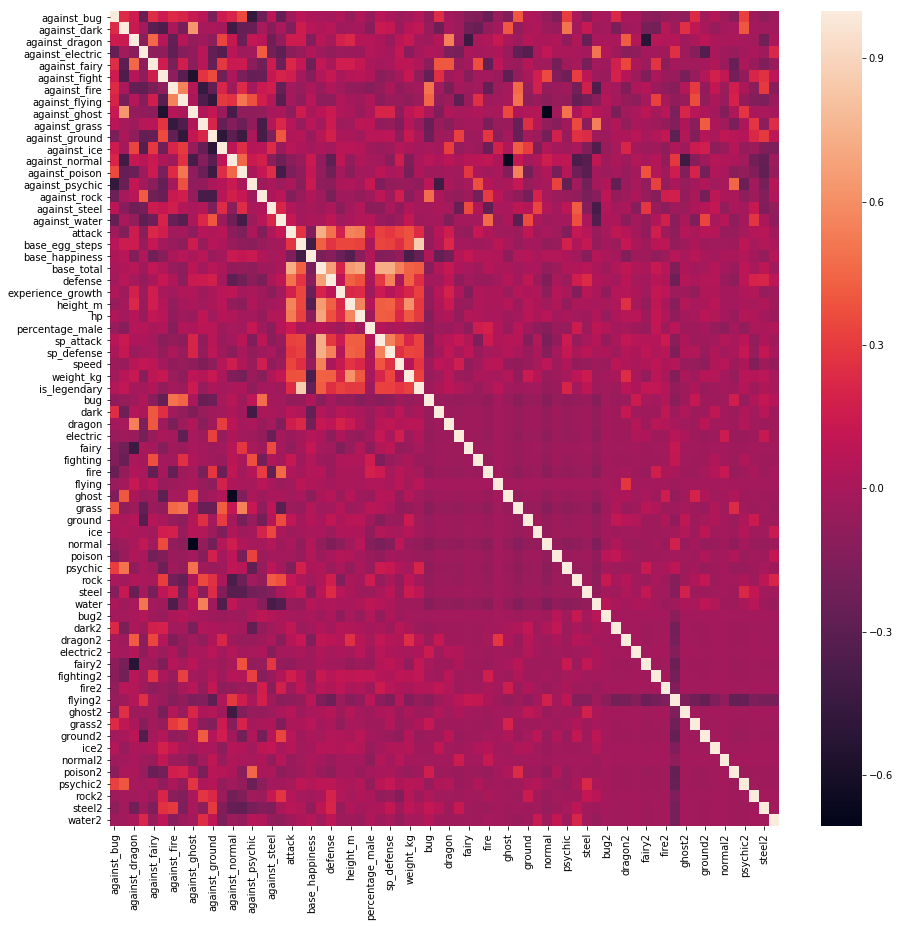

In [14]:
plt.figure(figsize=(15,15))
corr_data = data_stand.corr()
sns.heatmap(corr_data)
pass

In [24]:
corr_data.where(np.triu(corr_data > 0.6, k=1)).stack().sort_values(ascending=False)


base_egg_steps  is_legendary     0.854411
base_total      sp_defense       0.733267
                sp_attack        0.731916
attack          base_total       0.731187
base_total      hp               0.695049
                defense          0.660920
                height_m         0.650426
against_dark    against_ghost    0.637724
height_m        weight_kg        0.618478
dtype: float64

Исключим следующие признаки: base_total, against_dark, weight_kg.

In [26]:
del data_stand['base_total']
del data_stand['against_dark']
del data_stand['weight_kg']

Посмотрим, повлияет ли это на работу классификатора.

In [27]:
y = main_data['is_legendary']
X = data_stand.drop(['is_legendary'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_train)
score1 = np.mean(y_train != knn.predict(x_train))
score2 = np.mean(y_test  != knn.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.06506849315068493
Ошибка на тестовой выборке:  0.061224489795918366


In [28]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 14)
model.fit(x_train, y_train)
y_predict = model.predict(x_train)
score1 = np.mean(y_train != model.predict(x_train))
score2 = np.mean(y_test  != model.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.006802721088435374


In [31]:
y_predict = model.predict(x_test)
confusion_matrix(y_test, y_predict)

array([[138,   0],
       [  1,   8]], dtype=int64)

Исключение коррелированных переменных не привело к принципиальным изменениям.


## Борьба с несбалансировостью классов.

Посмотрим, какое количество наблюдений приходится на каждый из классов целевой переменной

In [38]:
main_data['is_legendary'].value_counts()

0    683
1     48
Name: is_legendary, dtype: int64

Видим несбалансировось классов. Попробуем применить алгоритм SMOTE для ее устранения.

In [8]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
x_train, y_train = sm.fit_resample(x_train, y_train.ravel())
x_test, y_test = sm.fit_resample(x_test, y_test.ravel())

In [14]:
print("Количесво объектов класса '1' в обучающей выбоке: {}".format(sum(y_train == 1)))
print("Количесво объектов класса '0' в обучающей выбоке: {} \n".format(sum(y_train == 0)))

print("Количесво объектов класса '1' в обучающей выбоке: {}".format(sum(y_test == 1)))
print("Количесво объектов класса '0' в обучающей выбоке: {} \n".format(sum(y_test == 0)))

Количесво объектов класса '1' в обучающей выбоке: 545
Количесво объектов класса '0' в обучающей выбоке: 545 

Количесво объектов класса '1' в обучающей выбоке: 138
Количесво объектов класса '0' в обучающей выбоке: 138 



In [15]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_train)
score1 = np.mean(y_train != knn.predict(x_train))
score2 = np.mean(y_test  != knn.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.030275229357798167
Ошибка на тестовой выборке:  0.10144927536231885


In [16]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 14)
model.fit(x_train, y_train)
y_predict = model.predict(x_train)
score1 = np.mean(y_train != model.predict(x_train))
score2 = np.mean(y_test  != model.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.014492753623188406


Сбалансированность классов уменьшиол ошибку для классификатора ближайших соседей на обучающей выборке, и, напротив, увеличила для классификатора случайного леса. 